# 1. Build an image segmentation model using pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
class BirdSoundsDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_paths = sorted([os.path.join(root, 'images', img) for img in os.listdir(os.path.join(root, 'images'))])
        self.mask_paths = sorted([os.path.join(root, 'masks', img) for img in os.listdir(os.path.join(root, 'masks'))])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)
        return image, mask

# Data transformations
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])


transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

train_dataset = BirdSoundsDataset(root='/content/drive/MyDrive/new_dataset/train', transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = BirdSoundsDataset(root='/content/drive/MyDrive/new_dataset/valid', transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = BirdSoundsDataset(root='/content/drive/MyDrive/new_dataset/test', transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        # Pooling
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.upconv4 = self.upconv_block(512, 256)
        self.upconv3 = self.upconv_block(512, 128)
        self.upconv2 = self.upconv_block(256, 64)
        self.upconv1 = self.upconv_block(128, 64)
        # Final Convolution
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        # Decoding path
        dec4 = self.upconv4(enc4)
        dec4 = torch.cat((dec4, enc3), dim=1)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc2), dim=1)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc1), dim=1)

        dec1 = self.upconv1(dec2)

        output = self.final_conv(dec1)
        return torch.sigmoid(output)


# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Initialize model, criterion, and optimizer
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 35
best_val_loss = float('inf')

train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Training Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (images, masks) in train_pbar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Resize masks to match the output size
        masks = nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        train_pbar.set_postfix({'Loss': loss.item()})

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    val_pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f'Validation Epoch {epoch+1}/{num_epochs}')
    with torch.no_grad():
        for batch_idx, (images, masks) in val_pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Resize masks to match the output size
            masks = nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')

            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            val_pbar.set_postfix({'Loss': loss.item()})

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:  # Save the model if validation loss decreases
        best_val_loss = val_loss
        model_save_path = '/content/drive/MyDrive/new_dataset/BirdSoundSeg_model.pth'
        torch.save(model.state_dict(), model_save_path)
        print(f'Saved Best Model with Val Loss: {best_val_loss:.4f}')

Validation Epoch 1/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.103]


Epoch 1/35, Train Loss: 0.2064, Val Loss: 0.1127
Saved Best Model with Val Loss: 0.1127


Validation Epoch 2/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0723]


Epoch 2/35, Train Loss: 0.1117, Val Loss: 0.0901
Saved Best Model with Val Loss: 0.0901


Validation Epoch 3/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0612]


Epoch 3/35, Train Loss: 0.0935, Val Loss: 0.0795
Saved Best Model with Val Loss: 0.0795


Validation Epoch 4/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0636]


Epoch 4/35, Train Loss: 0.0919, Val Loss: 0.0803


Validation Epoch 5/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0584]


Epoch 5/35, Train Loss: 0.0891, Val Loss: 0.0753
Saved Best Model with Val Loss: 0.0753


Validation Epoch 6/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.062]


Epoch 6/35, Train Loss: 0.0839, Val Loss: 0.0801


Validation Epoch 7/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.051]


Epoch 7/35, Train Loss: 0.0813, Val Loss: 0.0744
Saved Best Model with Val Loss: 0.0744


Validation Epoch 8/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0555]


Epoch 8/35, Train Loss: 0.0792, Val Loss: 0.0753


Validation Epoch 9/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.049]


Epoch 9/35, Train Loss: 0.0794, Val Loss: 0.0696
Saved Best Model with Val Loss: 0.0696


Validation Epoch 10/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0521]


Epoch 10/35, Train Loss: 0.0788, Val Loss: 0.0702


Validation Epoch 11/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0524]


Epoch 11/35, Train Loss: 0.0763, Val Loss: 0.0720


Validation Epoch 12/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0489]


Epoch 12/35, Train Loss: 0.0746, Val Loss: 0.0692
Saved Best Model with Val Loss: 0.0692


Validation Epoch 13/35: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s, Loss=0.0509]


Epoch 13/35, Train Loss: 0.0736, Val Loss: 0.0702


Validation Epoch 14/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0524]


Epoch 14/35, Train Loss: 0.0715, Val Loss: 0.0766


Validation Epoch 15/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.052]


Epoch 15/35, Train Loss: 0.0698, Val Loss: 0.0694


Validation Epoch 16/35: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s, Loss=0.0521]


Epoch 16/35, Train Loss: 0.0704, Val Loss: 0.0715


Validation Epoch 17/35: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s, Loss=0.0499]


Epoch 17/35, Train Loss: 0.0704, Val Loss: 0.0693


Validation Epoch 18/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0515]


Epoch 18/35, Train Loss: 0.0690, Val Loss: 0.0779


Validation Epoch 19/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0492]


Epoch 19/35, Train Loss: 0.0671, Val Loss: 0.0698


Validation Epoch 20/35: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s, Loss=0.0511]


Epoch 20/35, Train Loss: 0.0660, Val Loss: 0.0716


Validation Epoch 21/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0497]


Epoch 21/35, Train Loss: 0.0663, Val Loss: 0.0699


Validation Epoch 22/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.047]


Epoch 22/35, Train Loss: 0.0655, Val Loss: 0.0680
Saved Best Model with Val Loss: 0.0680


Validation Epoch 23/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0496]


Epoch 23/35, Train Loss: 0.0635, Val Loss: 0.0712


Validation Epoch 24/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0484]


Epoch 24/35, Train Loss: 0.0636, Val Loss: 0.0684


Validation Epoch 25/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0472]


Epoch 25/35, Train Loss: 0.0604, Val Loss: 0.0735


Validation Epoch 26/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0497]


Epoch 26/35, Train Loss: 0.0599, Val Loss: 0.0698


Validation Epoch 27/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0479]


Epoch 27/35, Train Loss: 0.0598, Val Loss: 0.0684


Validation Epoch 28/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0472]


Epoch 28/35, Train Loss: 0.0578, Val Loss: 0.0757


Validation Epoch 29/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0498]


Epoch 29/35, Train Loss: 0.0562, Val Loss: 0.0750


Validation Epoch 30/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0475]


Epoch 30/35, Train Loss: 0.0559, Val Loss: 0.0716


Validation Epoch 31/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0462]


Epoch 31/35, Train Loss: 0.0543, Val Loss: 0.0733


Validation Epoch 32/35: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s, Loss=0.0507]


Epoch 32/35, Train Loss: 0.0532, Val Loss: 0.0783


Validation Epoch 33/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0491]


Epoch 33/35, Train Loss: 0.0503, Val Loss: 0.0786


Validation Epoch 34/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0491]


Epoch 34/35, Train Loss: 0.0490, Val Loss: 0.0818


Validation Epoch 35/35: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s, Loss=0.0503]

Epoch 35/35, Train Loss: 0.0490, Val Loss: 0.0828


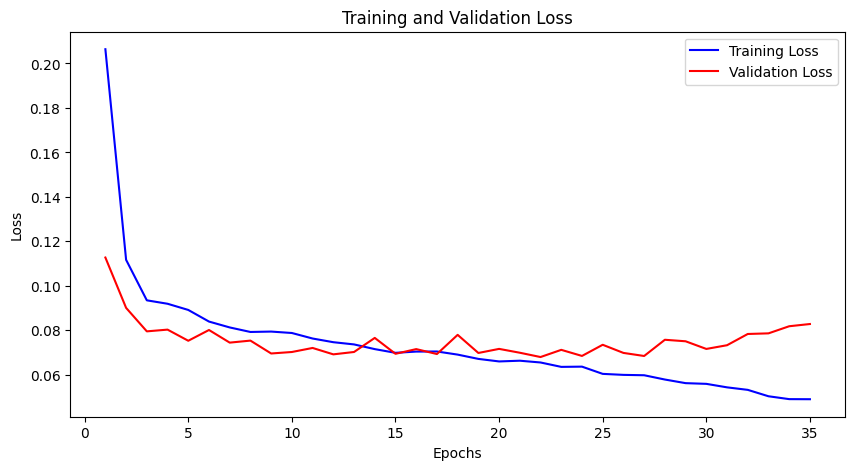

In [ ]:
# Plot the loss
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3.Evaluate your model using the test images

In [ ]:
# Define the IoU metric
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()
    true_mask = (true_mask > threshold).float()
    intersection = (pred_mask * true_mask).sum(dim=(1, 2, 3))
    union = pred_mask.sum(dim=(1, 2, 3)) + true_mask.sum(dim=(1, 2, 3)) - intersection
    iou = intersection / (union + 1e-6)
    return iou.mean().item()

# Data transformations
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to the saved model
model_path = '/content/drive/MyDrive/new_dataset/BirdSoundSeg_model.pth'

# Load the test dataset and dataloader
test_dataset = BirdSoundsDataset(root='/content/drive/MyDrive/new_dataset/test', transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 4. Your IoU score should be higher than 60

In [ ]:
# Load the saved model
model = UNet().to(device)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the test data
    test_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        test_pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Testing')
        for batch_idx, (images, masks) in test_pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Resize masks to match the output size
            masks = nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')

            iou = calculate_iou(outputs, masks)
            test_iou += iou * images.size(0)
            num_samples += images.size(0)

            test_pbar.set_postfix({'IoU': iou})

    # Calculate average IoU over the test set
    test_iou /= num_samples

    print(f'Test IoU: {test_iou:.4f}')
else:
    print("Model file not found.")

Testing: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, IoU=0.506]

Test IoU: 0.6323


# 5. Write a 3-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


Research Gate: https://www.researchgate.net/publication/387187054_A_Deep_Learning_Framework_for_Bird_Vocalization_Segmentation

Github:https://github.com/priyadarshini-777/https-www.researchgA_Deep_Learning_Framework_for_Bird_Vocalization_Segmentation

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 0.6 -->10 points
     < 0.5  --> 0 points
     >= 0.5 & < 0.6  --> 1 point/0.01 higher
     

(6). Discussion - 10 points